# Training Notebook

## 1. Install and import required libraries

In [4]:
#install the required libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install chart_studio
!pip install --upgrade nbformat
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install pandas_datareader

In [1]:
#import the installed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
%matplotlib inline
import nbformat
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected = True)

## 2. Load the dataset

In [2]:
#load the apple dataset
apple = pd.read_csv('D:/AI/apple_prediction/AAPL.csv')

In [3]:
#to see the whole inforamtion contenet of the above dataset:
apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5036 entries, 0 to 5035
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5036 non-null   object 
 1   Open       5036 non-null   float64
 2   High       5036 non-null   float64
 3   Low        5036 non-null   float64
 4   Close      5036 non-null   float64
 5   Adj Close  5036 non-null   float64
 6   Volume     5036 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 275.5+ KB


In [4]:
#to see the first five data content of the above dataset:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2/24/2003,0.265357,0.268393,0.246429,0.263214,0.224026,180252800
1,2/25/2003,0.262143,0.269286,0.260357,0.268214,0.228282,188641600
2,2/26/2003,0.267679,0.268214,0.258571,0.258929,0.220379,217095200
3,2/27/2003,0.260179,0.267857,0.259107,0.265357,0.225850,154341600
4,2/28/2003,0.265357,0.269464,0.263750,0.268036,0.228130,195098400


## 3. Prepare the dataset

In [5]:
#covert the date column into date time using pandas
apple['Date'] = pd.to_datetime(apple['Date'])

In [6]:
#to get the days in the last 20 years 
print(f'The dataframe contians stocks price between {apple.Date.min()} to {apple.Date.max()} is:')
days = apple.Date.max() - apple.Date.min()
print(f'Total days = {(days).days} days')

The dataframe contians stocks price between 2003-02-24 00:00:00 to 2023-02-23 00:00:00 is:
Total days = 7304 days


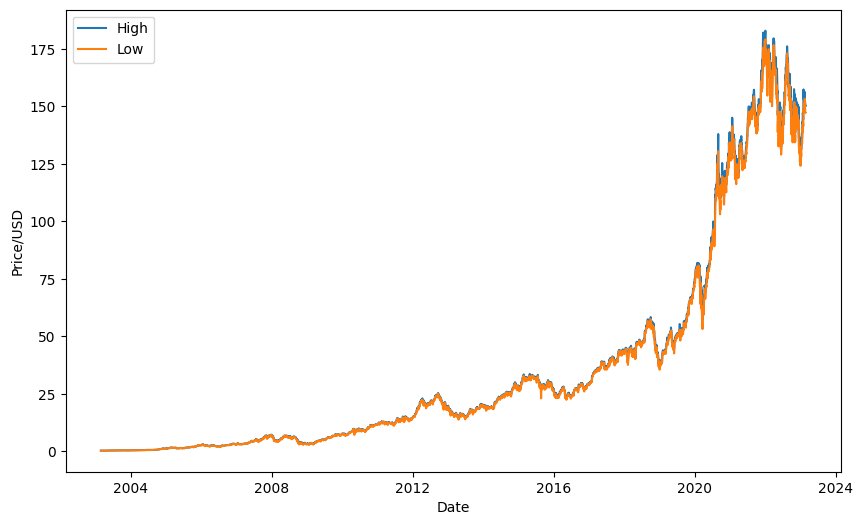

In [7]:
#plotting the LOW Vs HIGH
plt.figure(figsize = (10,6))
plt.plot(apple['Date'], apple['High'], label = 'High')
plt.plot(apple['Date'], apple['Low'], label = 'Low')
plt.xlabel('Date')
plt.ylabel('Price/USD')
plt.legend()
plt.gcf().autofmt_xdate
plt.show()

In [8]:
#find out statstic parameter using describe function
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5036.000000,5036.000000,5036.000000,5036.000000,5036.000000,5.036000e+03
mean,35.346956,35.749279,34.952580,35.366967,33.964792,4.168497e+08
std,45.442383,46.012425,44.899030,45.480566,45.413599,3.930372e+08
min,0.231964,0.235536,0.227143,0.234286,0.199405,3.519590e+07
25%,4.429732,4.503839,4.347589,4.428482,3.769163,1.276466e+08
50%,18.750000,18.932143,18.607143,18.763571,16.394505,2.859724e+08
75%,42.528752,42.915626,42.161876,42.461250,40.544452,5.837370e+08
max,182.630005,182.940002,179.119995,182.009995,180.683853,3.372970e+09


<Axes: >

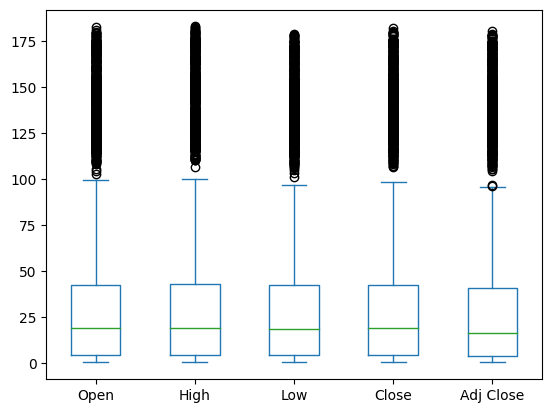

In [9]:
#prepare a box to hold each columns
apple[['Open','High','Low','Close','Adj Close']].plot(kind = 'box')

In [10]:
# setting the layout for the plot using go
layout = go.Layout(width=1000, height=700,
    title = 'Stocks Price for Apple Stocks',
    xaxis = dict(
        title = 'Date/time',
        titlefont = dict(
            family = 'Arial, monospace',
            size = 16,
            color = '#7f7f7f'
        )
    ),
    yaxis = dict(
        title = 'Price/USD',
        titlefont = dict(
            family = 'Arial, monospace',
            size = 16,
            color = '#7f7f7f'
        )
    )
)

apple_data = [{'x':apple['Date'], 'y':apple['Close']}]
plot = go.Figure(data = apple_data, layout = layout)

In [11]:
#plot offile using iplot library
iplot(plot)

# LSTM/RNN

In [12]:
#creat a dataset which only consists Closing prices
apple["Close"] = pd.to_numeric(apple.Close, errors = 'coerce' )
apple = apple.dropna()
# create a numpy arrary not a vector:
train_data = apple.iloc[:,4:5].values

In [13]:
train_data

array([[  0.263214],
       [  0.268214],
       [  0.258929],
       ...,
       [148.479996],
       [148.910004],
       [149.399994]])

In [14]:
#scale the dataset between 0 to 1
sc = MinMaxScaler(feature_range = (0,1))
train_data = sc.fit_transform(train_data)
train_data.shape

(5036, 1)

In [29]:
# split the dataset into training and testing sets
train_size = int(len(train_data) * 0.80)
test_size = len(train_data) - train_size
train, test = train_data[0:train_size, :], train_data[train_size:len(train_data), :]

In [30]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# create the data to train our model on
look_back = 60
X_train, y_train = create_dataset(train, look_back=look_back)
X_test, y_test = create_dataset(test, look_back=look_back)

In [32]:
# reshape the data to be compatible with LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [33]:
#Build LSTM model using four layers each has 100 neurons
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_4 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_5 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)              

In [35]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [36]:
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose =2)

Epoch 1/5
124/124 - 29s - loss: 4.6341e-04 - mse: 4.6341e-04 - mae: 0.0121 - 29s/epoch - 233ms/step
Epoch 2/5
124/124 - 21s - loss: 1.3114e-04 - mse: 1.3114e-04 - mae: 0.0076 - 21s/epoch - 168ms/step
Epoch 3/5
124/124 - 20s - loss: 1.4633e-04 - mse: 1.4633e-04 - mae: 0.0086 - 20s/epoch - 159ms/step
Epoch 4/5
124/124 - 20s - loss: 1.0890e-04 - mse: 1.0890e-04 - mae: 0.0072 - 20s/epoch - 160ms/step
Epoch 5/5
124/124 - 20s - loss: 1.0566e-04 - mse: 1.0566e-04 - mae: 0.0072 - 20s/epoch - 161ms/step


In [37]:
hist = model.history

In [38]:
print(hist.history)

{'loss': [0.00046340652625076473, 0.0001311398227699101, 0.00014633298269473016, 0.00010889608529396355, 0.00010566480341367424], 'mse': [0.00046340652625076473, 0.0001311398227699101, 0.00014633298269473016, 0.00010889608529396355, 0.00010566480341367424], 'mae': [0.012067371048033237, 0.007635236717760563, 0.008645998314023018, 0.007153638638556004, 0.007189952302724123]}


In [39]:
#save the best model
model.save('best_model.h5')

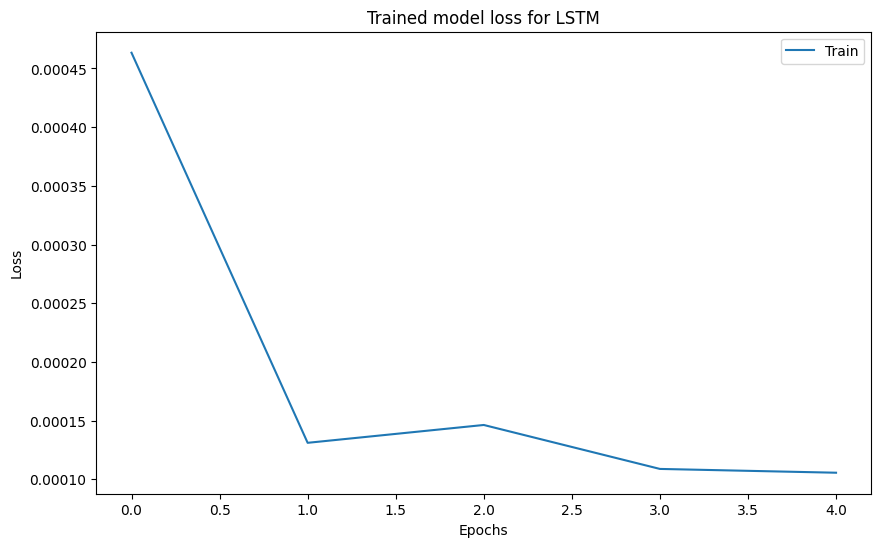

In [40]:
#Plot the training loss per epochs:
plt.figure(figsize = (10,6))
plt.plot(hist.history['loss'])
plt.title('Trained model loss for LSTM')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train'], loc = 'upper right')
plt.show()

In [41]:
# evaluate the model
mse = model.evaluate(X_test, y_test)[0]
print("MSE: ", mse)

30/30 [==============================] - 4s 67ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0909
MSE:  0.011160576716065407
